# 导入相关库及函数

In [1]:
import numpy as np
import pandas as pd
import tqdm
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import random
random.seed(0)
np.random.seed(0)
def get_flatten_features_targets(data,task='近1周'):
    data=pd.DataFrame(data)
    data['features']=data['基金类型'].astype('str')+','+data['rates']+','+data['values']+','+data['all_values']
    features=[[float(j) for j in i.split(',')]for i in data['features'].values]
    targets=[float(i) for i in data[task].values]
    return np.array(features),np.array(targets)

def get_rmse(targets,prds):
    rs=mean_squared_error(targets,prds)
    return np.sqrt(rs)

def train_model(features_tr,targets_tr,features_te,targets_te):
    rs_list=[]
    model_list=[]

    model=XGBRegressor(random_state=0,n_jobs=16,n_estimators=2000)
    model.fit(features_tr,targets_tr,early_stopping_rounds = 100,eval_set=[(features_te,targets_te)],verbose=False)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('XGBRegressor',rs)

    model=SVR(max_iter=-1,verbose=False,cache_size=10000)
    model.fit(features_tr,targets_tr)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('SVR',rs)

    model=LinearRegression()
    model.fit(features_tr,targets_tr)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('LinearRegression',rs)

    model=RandomForestRegressor(n_jobs=16)
    model.fit(features_tr,targets_tr)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('RandomForestRegressor',rs)

    return model_list,rs_list

d:\SETUP\anaconda\envs\py38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 数据读取

In [2]:
tmp=pd.read_parquet('fund_info.parquet')
tmp['na']=tmp['rates'].apply(lambda x:('na' in x) or ('Na' in x) or ('NA' in x) or (' ' in x))
tmp.drop(tmp[tmp['na']==True].index,inplace=True)
display(tmp.sample(5))

,基金代码,基金简称,日期,单位净值,累计净值,日增长率,近1周,近1月,近3月,成立来,...,values,all_values,dates_lenth,profit_std,beta,r_mean,treynor,sharpe,jense,na
1867,900057,中信增益十八个月持有债券C,2022-09-26,1.0868,1.2130,0.05,0.05,-0.71,-0.25,6.51,...,"1.0614,1.058,1.0528,1.0571,1.0588,1.0589,1.06,...","1.1876,1.1842,1.179,1.1833,1.185,1.1851,1.1862...",1484,0.2602225912217603,3.5530895031035628,0.016592592592592596,0.0010840852301883552,0.014802142403421566,0.18940208145837126,False
6902,011846,博时周期优选混合C,2022-09-26,0.8961,0.8961,0.03,-0.93,-7.14,-8.41,-10.39,...,"0.916,0.8879,0.8467,0.8755,0.8867,0.8989,0.903...","0.916,0.8879,0.8467,0.8755,0.8867,0.8989,0.903...",1484,1.6024461856105428,0.6074745162981287,-0.001999999999999997,-0.02426561171745757,-0.009198899078863242,0.016982928443717096,False
1746,006213,东方臻选纯债债券C,2022-09-26,1.0955,1.6535,0.01,0.07,0.47,1.68,71.54,...,"1.0711,1.0722,1.0713,1.0712,1.0712,1.0715,1.07...","1.6151,1.6162,1.6153,1.6152,1.6152,1.6155,1.61...",1484,0.030825318722576454,-3.857392849121295,0.02785185185185185,-0.00391744157314788,0.49021751395691926,-0.18633051545411208,False
9237,011917,山西证券品质生活混合A,2022-09-26,0.7686,0.7686,1.33,-2.08,-7.01,-12.96,-23.14,...,"0.8008,0.765,0.7319,0.7787,0.8083,0.8049,0.799...","0.8008,0.765,0.7319,0.7787,0.8083,0.8049,0.799...",1484,1.533652079949022,0.68502076725275,-0.020962962962962923,-0.04920099552437089,-0.021976107974126677,0.0020696030306066107,False
2916,004556,南方和元C,2022-09-26,1.0220,1.2240,0,0,0.29,1.09,24.53,...,"1.019,1.02,1.018,1.018,1.018,1.019,1.019,1.018...","1.201,1.202,1.2,1.2,1.2,1.201,1.201,1.2,1.2,1....",1484,0.06742832398311163,-1.5713623422014296,0.017703703703703704,-0.0031583822710235035,0.07360353438721101,-0.0770970704631117,False


Text(0.5, 1.0, '不同类型基金数量')

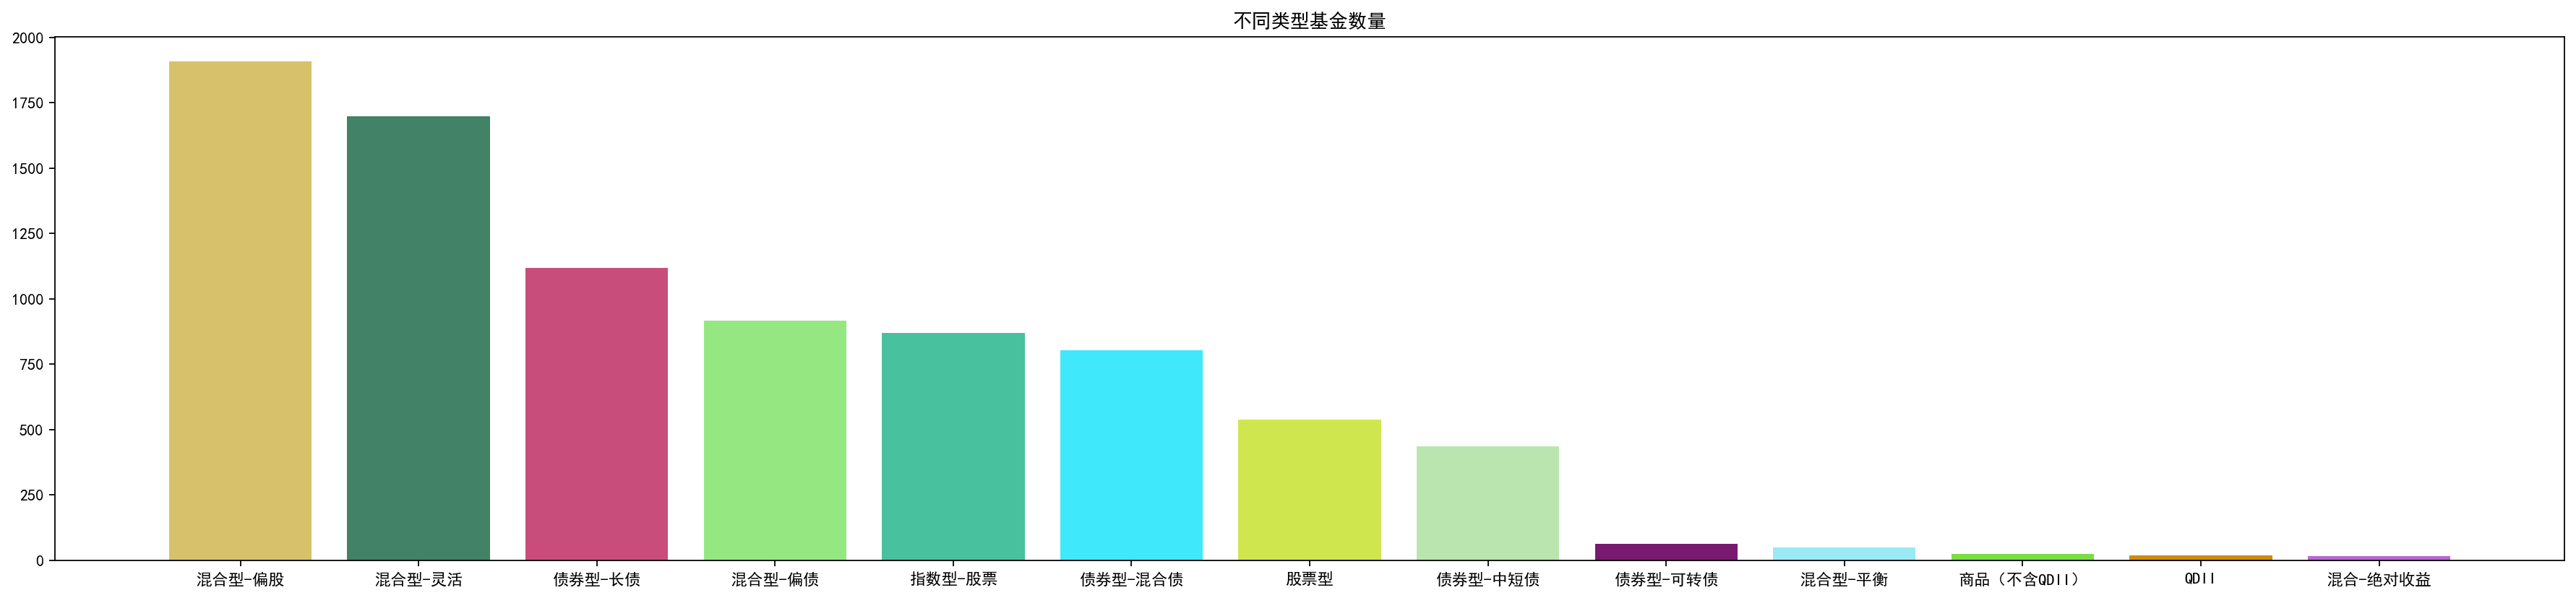

In [3]:
type_list=tmp['基金类型'].value_counts()
x_data=list(type_list.keys())
y_data=[type_list[i] for i in x_data]
colors=[(random.random(),random.random(),random.random()) for i in range(len(x_data))]
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(28,6),dpi=160)
plt.bar(x_data,y_data,color=colors)
plt.title("不同类型基金数量")

# 数据处理，划分数据集

In [4]:
row_data=pd.DataFrame(tmp[['基金代码','基金类型','近1周','近1月','rates','values','all_values']])
tmp_list=['混合型-偏股', '指数型-股票', '债券型-中短债', '债券型-长债', '债券型-混合债', '混合型-灵活','混合型-偏债', '股票型', '债券型-可转债', '混合型-平衡', '商品（不含QDII）', '混合-绝对收益','QDII']
row_data['基金类型']=row_data['基金类型'].apply(lambda x:tmp_list.index(x))
week_data=pd.DataFrame(row_data[['基金代码','基金类型','近1周','rates','values','all_values']])
month_data=pd.DataFrame(row_data[['基金代码','基金类型','近1月','rates','values','all_values']])
# print('cut values length')
# for i in tqdm.tqdm(['rates','values','all_values']):
for i in ['rates','values','all_values']:
    week_data[i]=week_data[i].apply(lambda x:','.join(x.split(',')[:-5]))
    month_data[i]=month_data[i].apply(lambda x:','.join(x.split(',')[:-22]))

train_week_data = week_data.sample(frac=0.8,random_state=0,axis=0)
test_week_data = week_data[~week_data.index.isin(train_week_data.index)]

train_month_data = month_data.sample(frac=0.8,random_state=0,axis=0)
test_month_data = month_data[~month_data.index.isin(train_month_data.index)]

# 训练模型

In [5]:
features_tr,targets_tr=get_flatten_features_targets(train_week_data)
features_te,targets_te=get_flatten_features_targets(test_week_data)
std_scaler=StandardScaler()
features_tr=std_scaler.fit_transform(features_tr)
features_te=std_scaler.transform(features_te)
models1,rsts1=train_model(features_tr,targets_tr,features_te,targets_te)

features_tr,targets_tr=get_flatten_features_targets(train_month_data,'近1月')
features_te,targets_te=get_flatten_features_targets(test_month_data,'近1月')
std_scaler=StandardScaler()
features_tr=std_scaler.fit_transform(features_tr)
features_te=std_scaler.transform(features_te)
models2,rsts2=train_model(features_tr,targets_tr,features_te,targets_te)

XGBRegressor 0.34213045358429267
SVR 0.501264443573565
LinearRegression 0.5702503599521764
RandomForestRegressor 0.3400463721029334
XGBRegressor 0.8008641086384446
SVR 1.1628913533044805
LinearRegression 1.1843947833677628
RandomForestRegressor 0.8725840824607831


Text(0.5, 1.0, 'Model Comparison (rmse)')

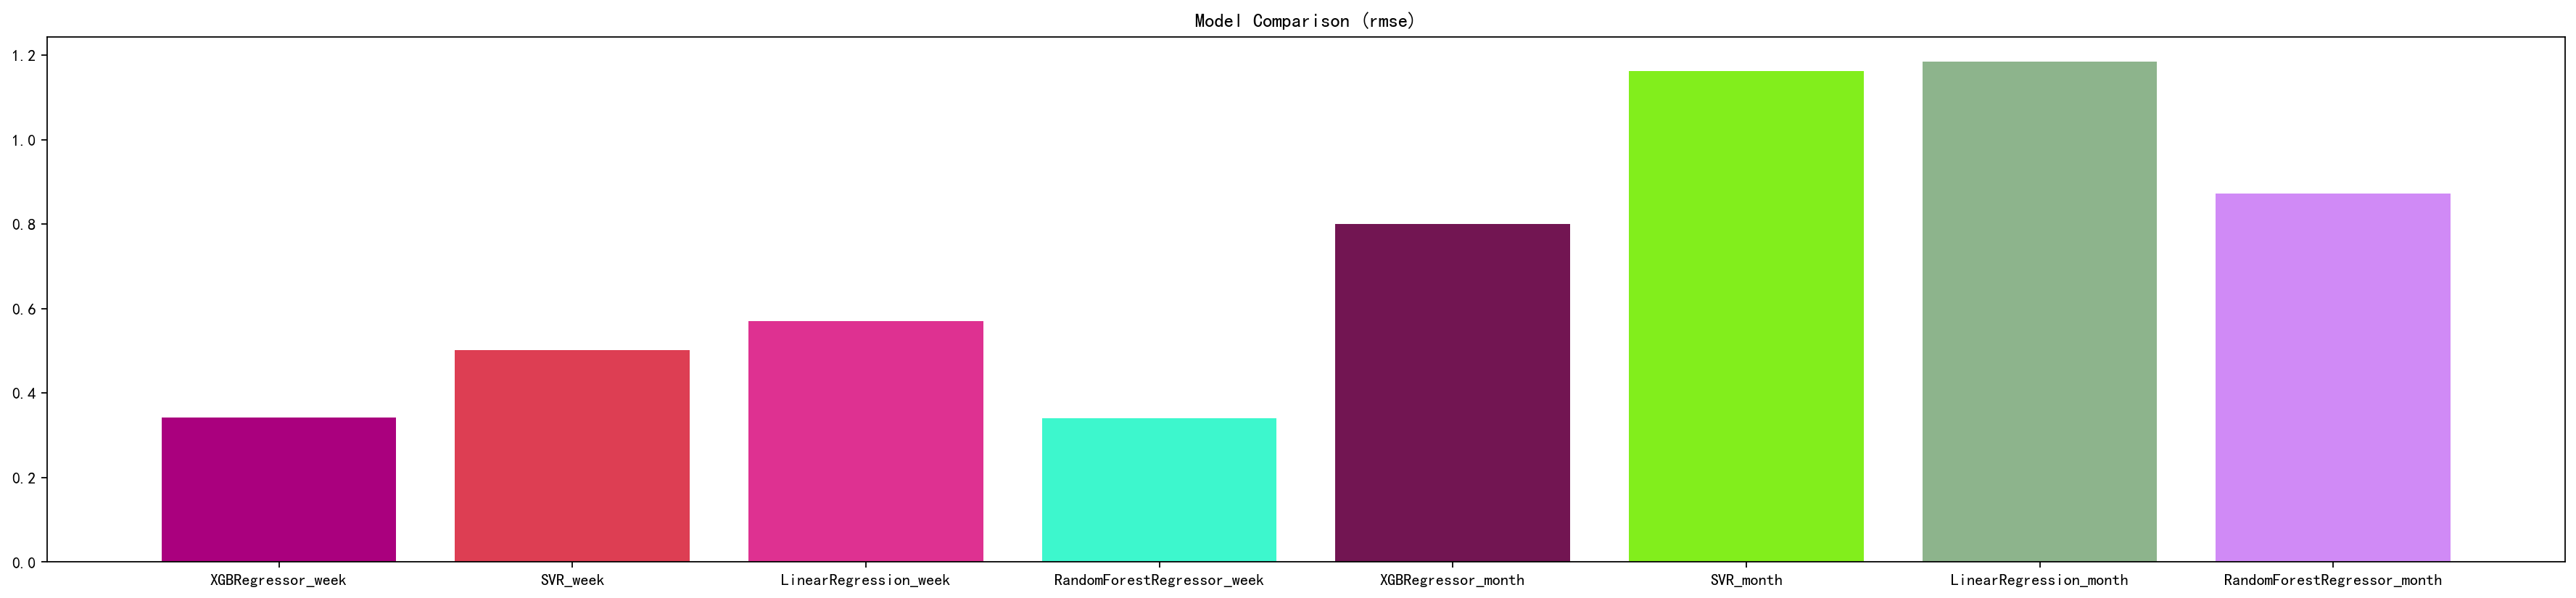

In [6]:
y_data =rsts1+rsts2
x_data =['XGBRegressor_week','SVR_week','LinearRegression_week','RandomForestRegressor_week','XGBRegressor_month','SVR_month','LinearRegression_month','RandomForestRegressor_month']
colors=[(random.random(),random.random(),random.random()) for i in range(len(x_data))]

plt.figure(figsize=(28,6),dpi=160)
plt.bar(x_data,y_data,color=colors)
plt.title("Model Comparison (rmse)")

In [7]:
week_data=pd.DataFrame(row_data[['基金类型','近1周','rates','values','all_values']])
month_data=pd.DataFrame(row_data[['基金类型','近1月','rates','values','all_values']])
# print('cut values length')
# for i in tqdm.tqdm(['rates','values','all_values']):
for i in ['rates','values','all_values']:
    week_data[i]=week_data[i].apply(lambda x:','.join(x.split(',')[5:]))
    month_data[i]=month_data[i].apply(lambda x:','.join(x.split(',')[22:]))

features_tr,targets_tr=get_flatten_features_targets(week_data)
prds=models1[0].predict(features_tr)
tmp['未来1周']=prds
tmp['未来1周']=tmp['未来1周'].astype('str')

features_tr,targets_tr=get_flatten_features_targets(month_data,'近1月')
prds=models2[0].predict(features_tr)
tmp['未来1月']=prds
tmp['未来1月']=tmp['未来1月'].astype('str')

tmp.to_parquet('fund_pred.parquet')

In [ ]:
from app import *
db.drop_all()
db.create_all()

insert_fund(
    tmp['基金代码'].values,
    tmp['基金简称'].values,
    tmp['拼音缩写'].values,
    tmp['基金类型'].values,
    tmp['日期'].values,
    tmp['单位净值'].values,
    tmp['累计净值'].values,
    tmp['日增长率'].values,
    tmp['近1周'].values,
    tmp['近1月'].values,
    tmp['近3月'].values,
    tmp['成立来'].values,
    tmp['dates'].values,
    tmp['rates'].values,
    tmp['values'].values,
    tmp['all_values'].values,
    tmp['profit_std'].values,
    tmp['beta'].values,
    tmp['r_mean'].values,
    tmp['treynor'].values,
    tmp['sharpe'].values,
    tmp['jense'].values,
    tmp['未来1周'].values,
    tmp['未来1月'].values,
)
